In [2]:
%load_ext autoreload
%autoreload 2
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import tensorflow.keras as keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
c = Image.open('sample_images/chicago.jpg')
s = Image.open('sample_images/starry.jpg')

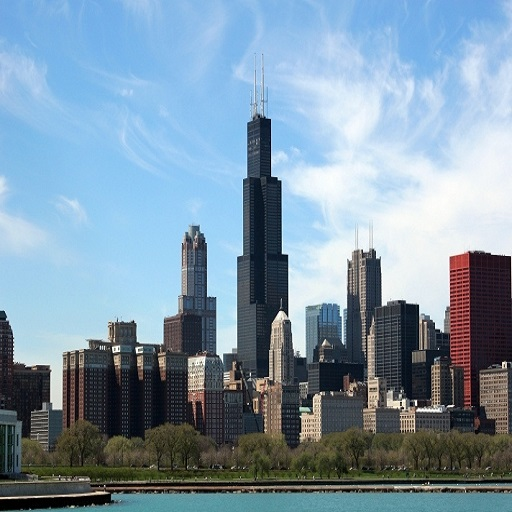

In [5]:
c

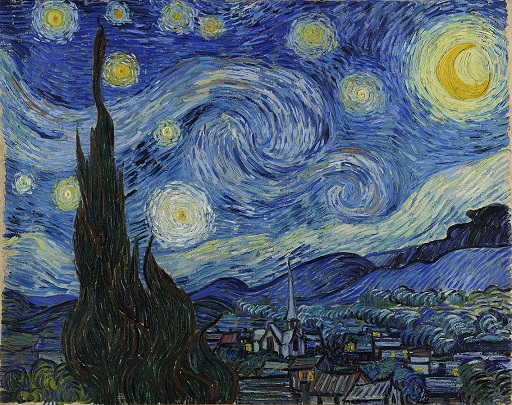

In [6]:
s

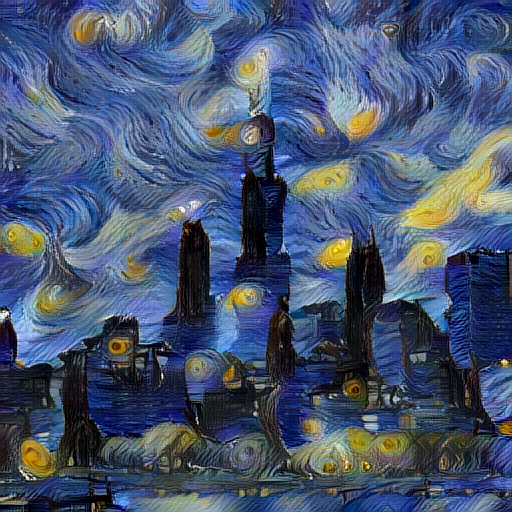

In [271]:
from model.model import Stylizer
net = Stylizer()
net(c,s,3)

In [384]:
from model.model import Encoder, Decoder, get_transformer

In [385]:
encoder = Encoder()
decoder = Decoder()
trfm = get_transformer()
encoder.requires_grad = False
decoder.requires_grad = False
trfm.requires_grad = False

In [437]:
iters = 1
dummy_content = torch.randn(1, 3, 512, 512, device='cpu')
dummy_style = torch.randn(1, 3, 512, 512, device='cpu')

with torch.no_grad():
    c4_1 = dummy_content.detach().clone()
    s4_1 = dummy_style.detach().clone()
    for _ in range(iters):
        out = encoder(c4_1)
        
        torch.onnx.export(encoder, c4_1, 
                          'encoder.onnx',
                          input_names=['image'],
                          output_names=('out4_1','out5_1'),
                          opset_version=10
                         )
        print('encoder out')
        c4_1, c5_1 = out
        s4_1, s5_1 = encoder(s4_1)

        
        c_tfm = trfm(c4_1, s4_1, c5_1, s5_1)
        
        torch.onnx.export(trfm, (c4_1, s4_1, c5_1, s5_1),
                          'transform.onnx',
                          input_names=['c4_1', 's4_1', 'c5_1', 's5_1'],
                          opset_version=10,
                          output_names=('c_tfm',)
                         )
        print('tfrm out')
        
        c_stylized = decoder(c_tfm)
        
        torch.onnx.export(decoder, c_tfm,
                         'decoder.onnx',
                          input_names=['c_tfm'],
                          opset_version=10,
                          output_names=('c_stylized',)
                         )
        print('decoder out')
        
        c4_1 = c_stylized.detach().clone()
        s4_1 = dummy_style.detach().clone()

        



# dummy_input = enc_model(dummy_input)

# trf_model = net.transform().cuda()


# dec_model = net.decoder.cuda()
# torch.onnx.export(dec_model,
#                   dummy_input,
#                   'decoder.onnx', 
#                   input_names=['encoded'],
#                  opset_version=11)



encoder out


c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\torch\onnx\symbolic_helper.py:381: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn("You are trying to export the model with " + onnx_op + " for ONNX opset version "


tfrm out
decoder out


In [442]:
!cmake

'cmake' is not recognized as an internal or external command,
operable program or batch file.


In [441]:
# !git clone --depth 1 https://github.com/onnx/onnx-tensorflow.git
!pip install -e onnx-tensorflow

Obtaining file:///C:/Users/tornikeo/Documents/work/up/adli/artstyle/website_js/onnx-tensorflow
  Using cached onnx-1.10.2.tar.gz (9.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  Using cached onnx-1.10.1.tar.gz (10.0 MB)
  Using cached onnx-1.10.0.tar.gz (10.0 MB)
  Using cached onnx-1.9.0.tar.gz (9.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Python310\python.exe' 'C:\Python310\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' get_requires_for_build_wheel 'C:\Users\tornikeo\AppData\Local\Temp\tmp9fcy0fp_'
       cwd: C:\Users\tornikeo\AppData\Local\Temp\pip-install-k7u5szur\onnx_f37914aff3064b5f92e7d7c274473ee5
  Complete output (19 lines):
  fatal: not a git repository (or any of the parent directories): .git
  Traceback (most recent call last):
    File "C:\Python310\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 349, in <module>
      main()
    File "C:\Python310\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 331, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
    File "C:\Python310\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 117, in get_requires_for_build_wheel
      return hook(config_settings)
    File "C:\Users\tornikeo\AppData\Local\Temp\pip-buil

In [387]:
import onnxruntime as ort
import onnx

In [388]:
def run_onnx(model_path, **kwargs):
    kwargs = {k:np.array(v) for k,v in kwargs.items()}
    out = ort.InferenceSession(model_path)\
        .run(None,input_feed=kwargs)    
    return out

In [389]:
crop = T.RandomCrop((512,512),pad_if_needed=True,padding_mode='reflect')
resize = T.Resize((512,512))
batch_dim = T.Lambda(lambda x:x[None,...])
to_tensor = T.ToTensor()

content_tfm = T.Compose((resize, to_tensor, batch_dim))
style_tfm = T.Compose((resize, to_tensor, batch_dim))

iters = 2
c_inp =content_tfm(c)
s_inp =style_tfm(s)

with torch.no_grad():
    c4_1 = c_inp.detach().clone()
    s4_1 = s_inp.detach().clone()
    for _ in range(iters):
        c4_1, c5_1 = run_onnx('encoder.onnx', image=c4_1)
        s4_1, s5_1 = run_onnx('encoder.onnx', image=s4_1)
        (c_tfm,) = run_onnx('transform.onnx', c4_1=c4_1,
                         s4_1=s4_1, c5_1=c5_1, s5_1=s5_1)
        (c_stylized,) = run_onnx('decoder.onnx', c_tfm=c_tfm)
        c4_1 = c_stylized#.detach().clone()
        s4_1 = s_inp#.detach().clone()
        c4_1 = c4_1.clip(0,1)

In [445]:
from pathlib import Path
from onnx_tf.backend import prepare
model_files = ['decoder.onnx','encoder.onnx','transform.onnx']
tf_files = []
for file in model_files:
    print(f'converting {file}')
    onnx_model = onnx.load(file,)  # load onnx model
    tf_rep = prepare(onnx_model,)  # prepare tf representation
    tf_model_path = f"model/weights/tf/{Path(file).stem}"
    tf_rep.export_graph(tf_model_path)  # export the model
    tf_files.append(tf_model_path)
    !onnx-tf convert -i {file} -o {Path(file).stem + '.tf2'}
    # break
# prepare()
# print_public_attributes(tf_rep)
# tf_rep.o

converting decoder.onnx


INFO:tensorflow:Assets written to: model/weights/tf/decoder\assets


INFO:tensorflow:Assets written to: model/weights/tf/decoder\assets
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-02-10 02:00:58,507 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2022-02-10 02:01:06.707125: W tensorflow/python/util/util.cc:368] Sets are not currently cons

converting encoder.onnx


INFO:tensorflow:Assets written to: model/weights/tf/encoder\assets


INFO:tensorflow:Assets written to: model/weights/tf/encoder\assets
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-02-10 02:01:20,090 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2022-02-10 02:01:28.701359: W tensorflow/python/util/util.cc:368] Sets are not currently cons

converting transform.onnx


INFO:tensorflow:Assets written to: model/weights/tf/transform\assets


INFO:tensorflow:Assets written to: model/weights/tf/transform\assets
c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-02-10 02:01:42,759 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2022-02-10 02:01:53.334723: W tensorflow/python/util/util.cc:368] Sets are not currently co

In [446]:
tf_encoder = tf.saved_model.load('model/weights/tf/encoder/')
tf_decoder = tf.saved_model.load('model/weights/tf/decoder/')
tf_trfm = tf.saved_model.load('model/weights/tf/transform/')

In [447]:
print_public_attributes(tf_encoder.signatures['serving_default'])
tf_encoder.signatures['serving_default'].structured_outputs

['add_gradient_functions_to_graph', 'add_to_graph', 'captured_inputs', 'function_def', 'graph', 'inputs', 'name', 'output_dtypes', 'output_shapes', 'outputs', 'pretty_printed_signature', 'replace_capture_with_deferred_capture', 'set_external_captures', 'structured_input_signature', 'structured_outputs', 'trainable_variables', 'variables']


{'out4_1': TensorSpec(shape=(1, 512, 64, 64), dtype=tf.float32, name='out4_1'),
 'out5_1': TensorSpec(shape=(1, 512, 32, 32), dtype=tf.float32, name='out5_1')}

In [448]:
def pil_to_tf(img):
    img = tf.keras.preprocessing.image.img_to_array(img,'channels_last',)[None,...] / 255.
    img = tf.image.resize(img, [512,512])
    img = tf.transpose(img, [0,3,1,2])
    return img
tf_c = pil_to_tf(c)
tf_s = pil_to_tf(s)

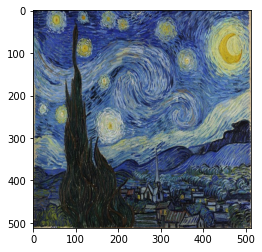

In [449]:
plt.imshow(tf.transpose(tf_c,[0,2,3,1])[0])
plt.imshow(tf.transpose(tf_s,[0,2,3,1])[0])

In [450]:
from operator import itemgetter
def print_public_attributes(obj):
    print(list([att for att in dir(obj) 
         if '__' not in att and not att.startswith('_')]))
    
print_public_attributes(tf_encoder)

c4_1 = tf_c
s4_1 = tf_s
for i in range(2):
    c4_1, c5_1 = itemgetter('out4_1', 'out5_1')(
        tf_encoder(image=c4_1))
    s4_1, s5_1 = itemgetter('out4_1', 'out5_1')(
        tf_encoder(image=s4_1))

    c_tfm = itemgetter('c_tfm')(
        tf_trfm(c4_1=c4_1,s4_1=s4_1, c5_1=c5_1, s5_1=s5_1))

    c_stylized = itemgetter('c_stylized')(
        tf_decoder(c_tfm=c_tfm))

    c4_1 = c_stylized#.detach().clone()
    s4_1 = tf_s#.detach().clone()
    c4_1 = tf.clip_by_value(c4_1,0,1)


['gen_tensor_dict', 'graph_debug_info', 'handler_variables', 'handlers', 'initializer_dict', 'outputs', 'signatures', 'tensorflow_git_version', 'tensorflow_version']


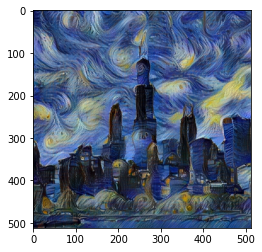

In [451]:
plt.imshow(tf.transpose(c4_1,[0,2,3,1])[0])

The error: `Error: Cannot infer the missing size in [-1,0] when there are 0 elements` was fixed by downloading onnx-tf directly from their repo and installing. Also needed to download cmake for windows and also, this is probably not important, I set `opset` param on torch onnx export to 10, instead from 11.

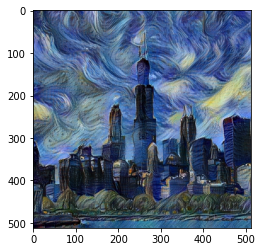

In [464]:
@tf.function(
    # jit_compile=True,
    input_signature=[tf.TensorSpec([1,3,512,512],tf.float32,'image'),]
)
def encode_tf(image):
    x = tf_encoder(image=image)
    c4_1 = tf.reshape(x['out4_1'],[1,512,64,64])
    c5_1 =  tf.reshape(x['out5_1'],[1,512,32,32])
    return c4_1, c5_1

@tf.function(
    # jit_compile=True,
    input_signature=[tf.TensorSpec([1,512,64,64],tf.float32,'c_tfm'),]
)
def decode_tf(c_tfm):
    x = tf_decoder(c_tfm=c_tfm)
    # c4_1 = tf.reshape(x['out4_1'],[1,512,64,64])
    # c5_1 =  tf.reshape(x['out5_1'],[1,512,32,32])
    return x['c_stylized']

@tf.function(
    # jit_compile=True,
    input_signature=[
        tf.TensorSpec([1,512,64,64],tf.float32,'c4_1'),
        tf.TensorSpec([1,512,64,64],tf.float32,'s4_1'),
        tf.TensorSpec([1,512,32,32],tf.float32,'c5_1'),
        tf.TensorSpec([1,512,32,32],tf.float32,'s5_1'),
    ]
)
def trfm_tf(c4_1, s4_1, c5_1, s5_1):
    x = tf_trfm(c4_1=c4_1, s4_1=s4_1, c5_1=c5_1, s5_1=s5_1)
    c_tfm = tf.reshape(x['c_tfm'],[1, 512, 64, 64])
    return c_tfm


class TFStylize(tf.Module):
    @tf.function(
        input_signature=[
            tf.TensorSpec([1,3,512,512],tf.float32,'content'),
            tf.TensorSpec([1,3,512,512],tf.float32,'style'),
            tf.TensorSpec([],tf.int32,'iters')
        ]
    )
    def __call__(self, content, style, iters):
        # c4_1 = tf.reshape(content,[1,3,512,512])
        # s4_1 = tf.reshape(style,[1,3,512,512])
        i = tf.constant(0, dtype=tf.int32)
        
        while tf.less(i, iters):
            c4_1, c5_1 = encode_tf(content)
            
            s4_1, s5_1 = encode_tf(style)
            
            c_tfm = trfm_tf(c4_1=c4_1,s4_1=s4_1, c5_1=c5_1, s5_1=s5_1)
            c_stylized = decode_tf(c_tfm=c_tfm)
            # content = decode_tf(c_tfm=c4_1)

#             content = tf.reshape(c_stylized,[1,3,512,512])#.detach().clone()
# #             x = tf_encoder(image=content)
            
# #             c4_1 = tf.reshape(x['out4_1'],[1,512,64,64])
# #             c5_1 =  tf.reshape(x['out5_1'],[1,512,32,32])
#             # tf.print(tf.shape(c5_1))
            
#             # x = tf_encoder(image=style)
#             # s4_1 = tf.reshape(x['out4_1'],[1,512,64,64])
#             # s5_1 = tf.reshape(x['out5_1'],[1,512,32,32])
#             # x = tf_trfm(c4_1=c4_1,s4_1=s4_1, c5_1=c5_1, s5_1=s5_1)
#             # c_tfm = tf.reshape(x['c_tfm'],[1, 512, 64, 64])
#             # tf.print(tf.shape(c_tfm))
# #             c_tfm = itemgetter('c_tfm')(
# #                 tf_trfm(c4_1=c4_1,s4_1=s4_1, c5_1=c5_1, s5_1=s5_1))
#             # x = tf_decoder(c_tfm=c_tfm)
#             # c_stylized =  tf.reshape(x['c_stylized'],[1,3,512,512])
# #             c_stylized = itemgetter('c_stylized')(
# #                 tf_decoder(c_tfm=c_tfm))
#             # style = style#.detach().clone()
            c4_1 = tf.clip_by_value(c4_1,0,1)
            i += 1
    
        return tf.clip_by_value(c_stylized,0,1)
    
tfs = TFStylize()
plt.imshow(tf.transpose(tfs(tf_c, tf_s, 4),[0,2,3,1])[0])

In [465]:
@tf.function
def signature(content, style, iters):
    content = tf.transpose(content, [2,0,1])[None,...]
    style = tf.transpose(style, [2,0,1])[None,...]
    return {'result':tf.transpose(tfs(content, style, iters)[0],[1,2,0])}

signature = signature.get_concrete_function(
    tf.random.normal((512,512,3)),
    tf.random.normal((512,512,3)),
    tf.TensorSpec([],tf.int32)
)

In [466]:
tf.saved_model.save(
    tfs,
    'experimental_tfsave',
    signatures=dict(
        serving_default=signature
    )
)

INFO:tensorflow:Assets written to: experimental_tfsave\assets


INFO:tensorflow:Assets written to: experimental_tfsave\assets


In [467]:
tfs = tf.saved_model.load('experimental_tfsave')

In [468]:
# print_public_attributes(tfs)
print_public_attributes(tfs.signatures['serving_default'])
tfs.signatures['serving_default'](content=tf.random.normal((512,512,3)), 
                                  style=tf.random.normal((512,512,3)),
                                  iters=tf.constant(1))
tfs.signatures['serving_default'].structured_outputs

['add_gradient_functions_to_graph', 'add_to_graph', 'captured_inputs', 'function_def', 'graph', 'inputs', 'name', 'output_dtypes', 'output_shapes', 'outputs', 'pretty_printed_signature', 'replace_capture_with_deferred_capture', 'set_external_captures', 'structured_input_signature', 'structured_outputs', 'trainable_variables', 'variables']


{'result': TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name='result')}

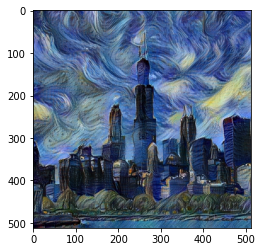

In [469]:
plt.imshow(tf.transpose(tfs(tf_c, tf_s, 1),[0,2,3,1])[0])

In [470]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    experimental_tfsave/ \
    experimental_jssave

Writing weight file experimental_jssave\model.json...
weight unknown_51 with shape (3,) and dtype int64 was auto converted to the type int32
weight unknown_29 with shape (3,) and dtype int64 was auto converted to the type int32
weight unknown_30 with shape (4,) and dtype int64 was auto converted to the type int32
weight unknown_31 with shape (1,) and dtype int64 was auto converted to the type int32
weight unknown_32 with shape (4,) and dtype int64 was auto converted to the type int32
weight unknown_27 with shape (3,) and dtype int64 was auto converted to the type int32
weight unknown_28 with shape (4,) and dtype int64 was auto converted to the type int32
weight unknown_33 with shape (1,) and dtype int64 was auto converted to the type int32
weight unknown_34 with shape (4,) and dtype int64 was auto converted to the type int32
weight unknown_49 with shape (3,) and dtype int64 was auto converted to the type int32
weight unknown_39 with shape (3,) and dtype int64 was auto converted to the 

In [17]:
# pip install tensorflowjs[wizard]

  Using cached PyInquirer-1.0.3-py3-none-any.whl
  Using cached prompt_toolkit-1.0.14-py3-none-any.whl (248 kB)
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.26
    Uninstalling prompt-toolkit-3.0.26:
      Successfully uninstalled prompt-toolkit-3.0.26
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 6.4.0 requires prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you have prompt-toolkit 1.0.14 which is incompatible.
ipython 8.0.1 requires prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you have prompt-toolkit 1.0.14 which is incompatible.
You should consider upgrading via the 'c:\users\tornikeo\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
